<a href="https://colab.research.google.com/github/jhChoi1997/EE488_AI_Convergence_Capstone_Design_Anomaly_Detection_2022spring/blob/main/Experiment1/Introduction_to_Anomaly_Detection_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EE 488 AI Convergence Capstone Design : Anomaly Detection**
## **practice 1-1 : Introduction to Anomaly Detection (Reconstruction)**
Anomaly detection can be done by various pretext tasks. In this session, we will do anomaly detection with reconstruction as a pretext task on the MNIST dataset. 💻

In [1]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
import matplotlib.pyplot as plt
import torchsummary
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
plt.rc('font', size=20)

You can change the hyperparameter below.
Parameter 'ANOMALY_NUM' means which number to set as an anomaly.

In [4]:
EPOCHS = 100
BATCH = 32
ANOMALY_NUM = 9

The dataset for anomaly detection is composed of normal data and anomaly data. Normal data can be seen in the train, validation, and test dataset, but anomaly data is not in the train dataset. Here 0 to 8 will be used as normal data, and 9 will be used as anomaly data.

In [5]:
mnist_train = datasets.MNIST(root='MNIST_data/', train=True, transform=ToTensor(), download=True)
mnist_test = datasets.MNIST(root='MNIST_data/', train=False, transform=ToTensor(), download=True)

train_normal = [mnist_train[i][0].numpy() for i, v in enumerate(mnist_train) if v[1] != ANOMALY_NUM]

train_dataset = torch.Tensor(train_normal)

unseen_x = torch.tensor([v[0].numpy() for v in mnist_test])
unseen_y = torch.tensor([0 if v[1] != ANOMALY_NUM else 1 for v in mnist_test])

val_x = unseen_x[:int(len(unseen_x) / 2)]
val_y = unseen_y[:int(len(unseen_y) / 2)]

test_x = unseen_x[int(len(unseen_x) / 2):]
test_y = unseen_y[int(len(unseen_y) / 2):]

val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


Dataset length is like below.

In [6]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

54051
5000
5000


You will use Auto Encoder for practice

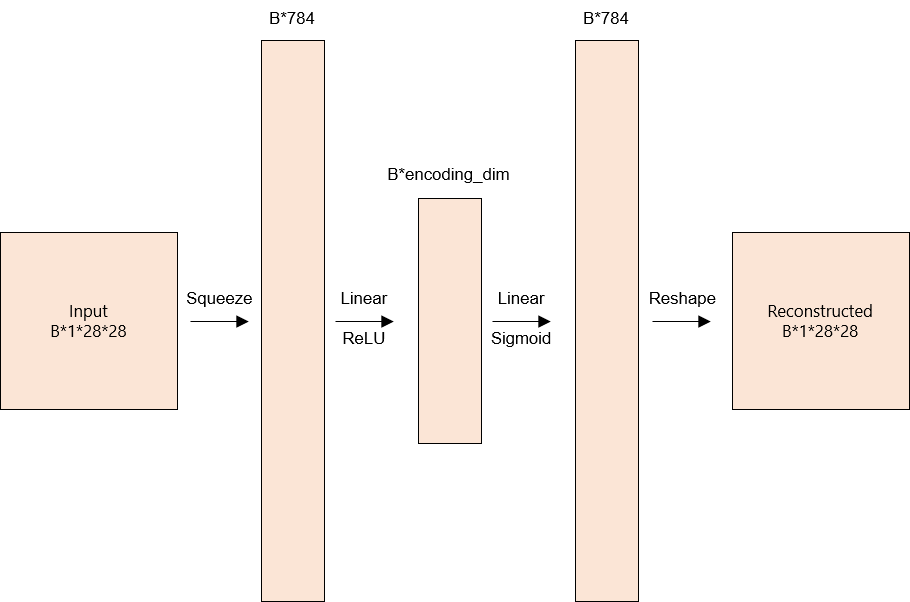

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoding_dim = encoding_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28, self.encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.encoding_dim, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = x.reshape(x.size(0), -1)
        out = self.encoder(out)
        out = self.decoder(out)
        out = out.view(x.size())
        return out

In [8]:
model = AutoEncoder(64).to(device)
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


In [9]:
loss_fn = nn.MSELoss()
anomaly_score = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    for batch, X in enumerate(dataloader):
        X = X.to(device)

        pred = model(X)
        loss = loss_fn(pred, X)

        for idata in range(pred.shape[0]):

            iloss = loss_fn(pred[idata,:,:], X[idata,:,:])
            losses.append(iloss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    losses = [i.item() for i in losses]
    return np.mean(losses)

Anomaly score is calculated in validation and test. Reconstruction error is commonly used as an anomaly score when using reconstruction as a pretext task. Since the model is trained with normal data, the model may not reconstruct anomaly data well, so the anomaly score of anomaly data will be higher than the anomaly score of normal data. And using different distributions of anomaly score, AUC (Area Under Cover) can be calculated.

In [11]:
def test(dataloader, model, loss_fn, anomaly_score, draw_mode = False):
    model.eval()

    y_true, y_pred = [], []

    normal_loss = []
    anomaly_loss = []

    with torch.no_grad():
      
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X)

            for idata in range(output.shape[0]):

                loss = loss_fn(output[idata,:,:], X[idata,:,:])
                if y[idata] == 0:
                    normal_loss.append(loss)
                elif y[idata] == 1:
                    anomaly_loss.append(loss)
            
            score = torch.mean(anomaly_score(X, output), (1, 2, 3))

            y_true.extend(y.tolist())
            y_pred.extend(score.tolist())

    roc_auc = metrics.roc_auc_score(y_true, y_pred)

    if draw_mode:
        fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
        plt.figure(figsize=(10,10))
        plt.plot(fpr,tpr)
        plt.title('ROC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')


    print(f'ROC AUC: {roc_auc:>0.3f}')
    normal_loss = [i.item() for i in normal_loss]
    anomaly_loss = [i.item() for i in anomaly_loss]
    normal_loss_mean = np.mean(normal_loss)
    anomaly_loss_mean = np.mean(anomaly_loss)
    print(f'normal loss : {normal_loss_mean}')
    print(f'anomaly loss : {anomaly_loss_mean}')
    return roc_auc.item(), normal_loss_mean, anomaly_loss_mean, normal_loss, anomaly_loss

See how reconstruction loss and AUC changes during training.
Loss is calculated during train and AUC is calculated during validation.

In [12]:
aucs = []
train_normal_losses = []
val_normal_losses = []
val_anomaly_losses = []
best_auc = 0
best_model = model.to(device)
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_normal_loss = train(train_dataloader, model, loss_fn, optimizer)
    auc, val_normal_loss, val_anomaly_loss, _, _ = test(val_dataloader, model, loss_fn, anomaly_score)
    train_normal_losses.append(train_normal_loss)
    aucs.append(auc)
    val_normal_losses.append(val_normal_loss)
    val_anomaly_losses.append(val_anomaly_loss)
    if best_auc < auc:
      best_model = model
      best_auc = auc

Epoch 1
-------------------------------
loss: 0.232261  [    0/54051]
loss: 0.044745  [ 9600/54051]
loss: 0.033627  [19200/54051]
loss: 0.024640  [28800/54051]
loss: 0.021466  [38400/54051]
loss: 0.014059  [48000/54051]
ROC AUC: 0.504
normal loss : 0.016187999225076057
anomaly loss : 0.016230604347163953
Epoch 2
-------------------------------
loss: 0.014818  [    0/54051]
loss: 0.014547  [ 9600/54051]
loss: 0.012330  [19200/54051]
loss: 0.010546  [28800/54051]
loss: 0.009914  [38400/54051]
loss: 0.007603  [48000/54051]
ROC AUC: 0.549
normal loss : 0.010901780996885333
anomaly loss : 0.011690399288916244
Epoch 3
-------------------------------
loss: 0.009948  [    0/54051]
loss: 0.008926  [ 9600/54051]
loss: 0.007473  [19200/54051]
loss: 0.007164  [28800/54051]
loss: 0.007590  [38400/54051]
loss: 0.005917  [48000/54051]
ROC AUC: 0.536
normal loss : 0.007358467079107608
anomaly loss : 0.007710344218783295
Epoch 4
-------------------------------
loss: 0.006911  [    0/54051]
loss: 0.0073

<Figure size 432x288 with 0 Axes>

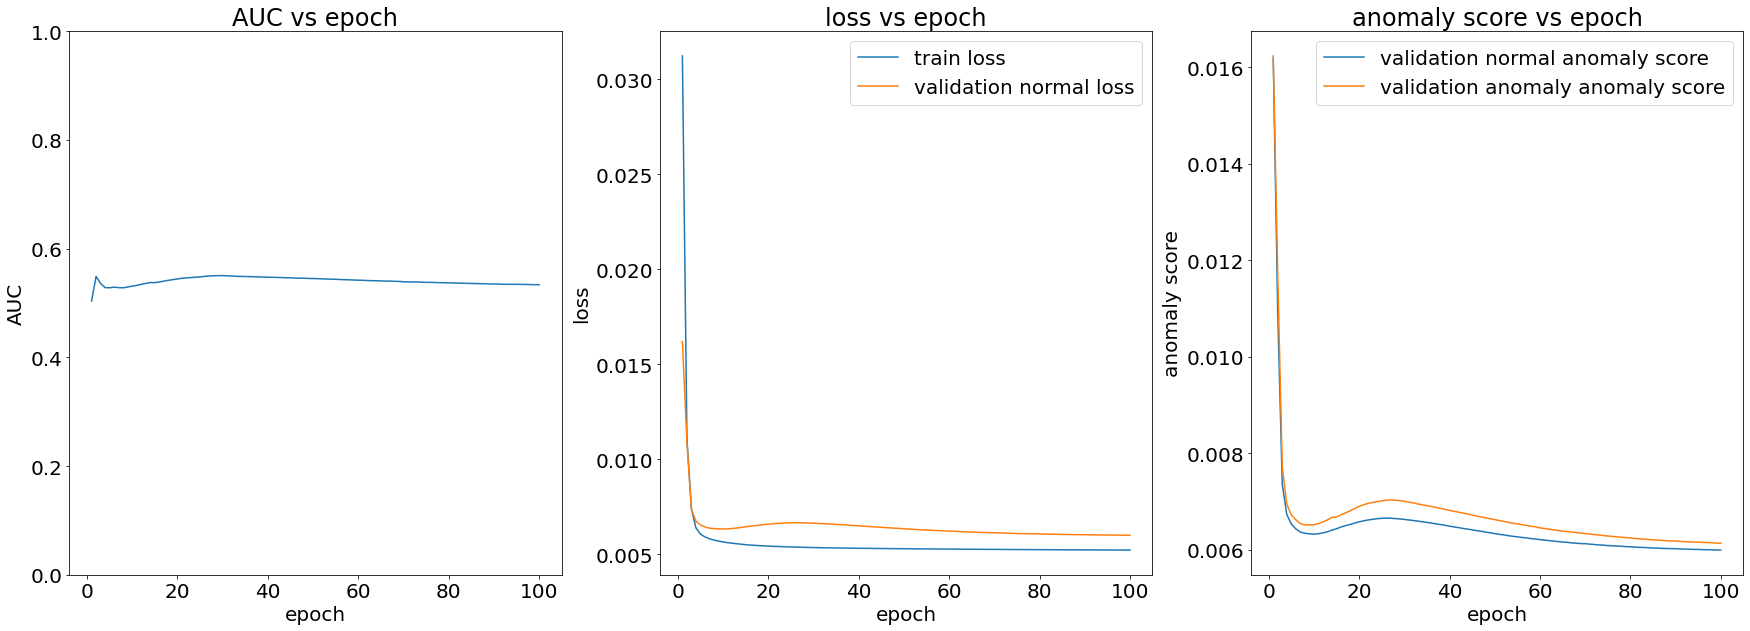

In [13]:
plt.clf()
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.plot(list(range(1,len(aucs)+1)),aucs)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(1,3,2)
plt.plot(list(range(1,len(train_normal_losses)+1)),train_normal_losses)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend(['train loss', 'validation normal loss'])

plt.subplot(1,3,3)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.plot(list(range(1,len(val_anomaly_losses)+1)),val_anomaly_losses)
plt.xlabel('epoch')
plt.ylabel('anomaly score')
plt.title('anomaly score vs epoch')
plt.legend(['validation normal anomaly score','validation anomaly anomaly score'])

Let's see performance on the test data.

ROC AUC: 0.497
normal loss : 0.005142348452873373
anomaly loss : 0.005005223728223096


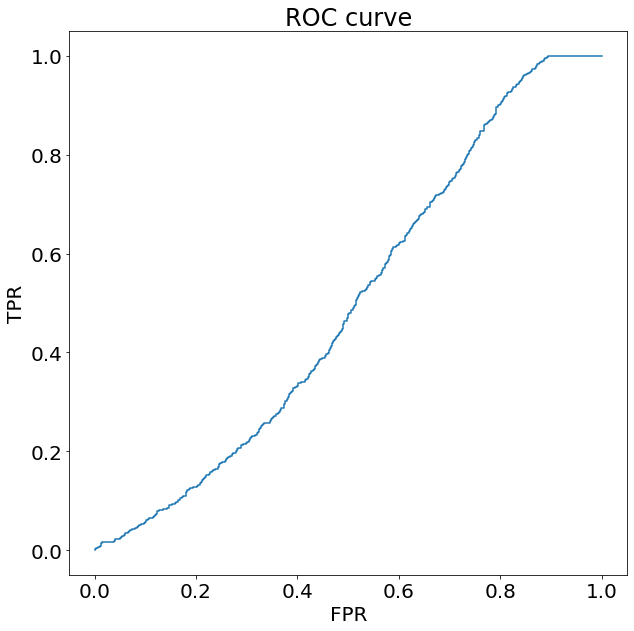

In [14]:
auc, _, _, test_normal_score, test_anomaly_score = test(test_dataloader, best_model, loss_fn, anomaly_score, True)

The let's see anomaly score of normal / anomaly data.

<Figure size 720x720 with 0 Axes>

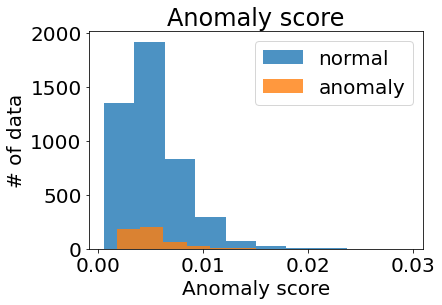

<Figure size 720x720 with 0 Axes>

In [15]:
plt.hist(test_normal_score, alpha = 0.8)
plt.hist(test_anomaly_score, alpha = 0.8)
plt.title('Anomaly score')
plt.xlabel('Anomaly score')
plt.ylabel('# of data')
plt.legend(['normal','anomaly'])
plt.figure(figsize=(10,10))

=============================================================================

Wait!!

How can we actually get ROC AUC from above figure?
Go through below code.

Below code shows length of normal data and anomaly data.

In [16]:
print(len(test_normal_score))
print(len(test_anomaly_score))

4511
489


First, let's fix threshold anomaly score and draw confusion matrix.

In [17]:
thres = 0.01 # modify here

P = len(test_anomaly_score)
N = len(test_normal_score)

test_normal_score_np = np.array(test_normal_score)
test_anomaly_score_np = np.array(test_anomaly_score)

is_normal_anomalous = test_normal_score_np > thres
is_anomaly_anomalous = test_anomaly_score_np > thres

TP = is_anomaly_anomalous.sum()
FN = P - TP
FP = is_normal_anomalous.sum()
TN = N - FP

print(f'TP : {TP} FN : {FN} FP : {FP} TN : {TN}')


TP : 17 FN : 472 FP : 288 TN : 4223


In [18]:
import tabulate
table = [['Pred / True', 'P', 'N'],['P',f'TP:{TP}',f'FP:{FP}'],['N',f'FN:{FN}',f'TN:{TN}']]
print('confusion matrix')
print(tabulate.tabulate(table, headers = 'firstrow', tablefmt = 'grid'))

confusion matrix
+---------------+--------+---------+
| Pred / True   | P      | N       |
+===============+========+=========+
| P             | TP:17  | FP:288  |
+---------------+--------+---------+
| N             | FN:472 | TN:4223 |
+---------------+--------+---------+


Now let's calculate TPR, FPR. Also let's calculate precision, recall and f1 score.

In [19]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
print(f'TPR : {TPR} FPR : {FPR} precision : {Precision} recall : {Recall}')

TPR : 0.034764826175869123 FPR : 0.06384393704278431 precision : 0.05573770491803279 recall : 0.034764826175869123


Change the threshold and check how each value changes.

Now move threshold to get ROC curve. Then calculate ROC AUC.

In [20]:
np.max([1,3])

3

ROC AUC : 0.49708392890090525


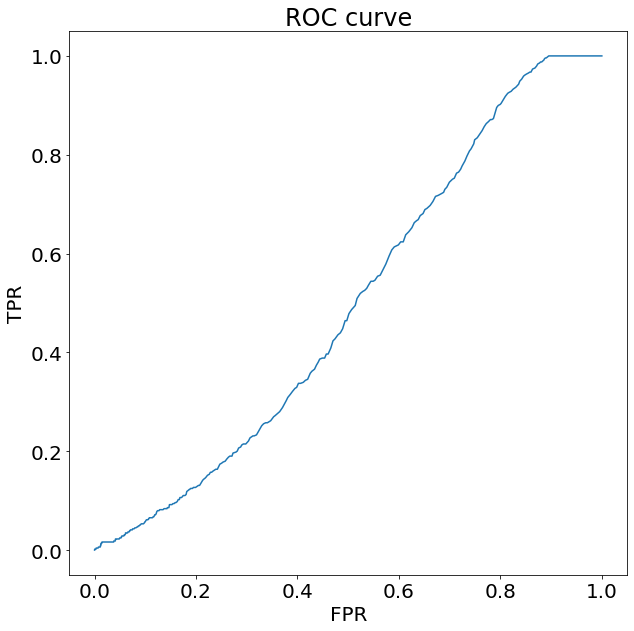

In [21]:
P = len(test_anomaly_score)
N = len(test_normal_score)

test_normal_score_np = np.array(test_normal_score)
test_anomaly_score_np = np.array(test_anomaly_score)

max_val = np.max([np.max(test_normal_score_np), np.max(test_anomaly_score_np)])

thres = np.linspace(0,max_val,num=1000)

TPR_list = []
FPR_list = []

for ithres in thres:
  is_normal_anomalous = test_normal_score_np > ithres
  is_anomaly_anomalous = test_anomaly_score_np > ithres

  TP = is_anomaly_anomalous.sum()
  FN = P - TP
  FP = is_normal_anomalous.sum()
  TN = N - FP

  TPR = TP/(TP+FN)
  FPR = FP/(FP+TN)

  TPR_list.append(TPR)
  FPR_list.append(FPR)


plt.figure(figsize=(10,10))
plt.plot(FPR_list,TPR_list)
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

AUC = np.trapz(np.flip(np.array(TPR_list)).tolist(),np.flip(np.array(FPR_list)).tolist())
print(f'ROC AUC : {AUC}')

=============================================================================

Below code plots figure of the original input image and reconstructed image.

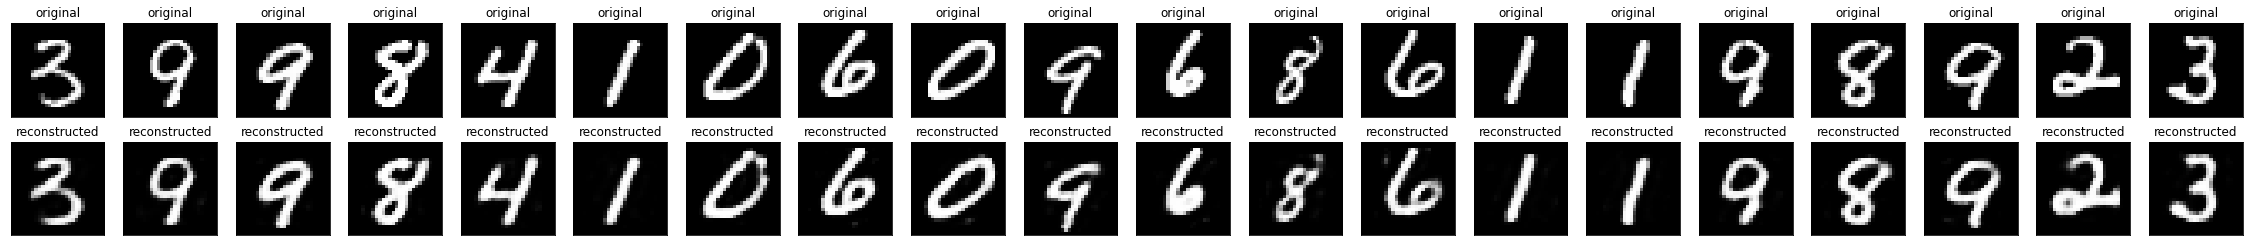

In [22]:
plt.rc('font', size=10)
n = 20
plt.figure(figsize=(2*n, 4))


for i in range(n):
  input_image = test_dataset[i][0].to(device)
  output_image = best_model(input_image.unsqueeze(0))

  ax = plt.subplot(2, n, i + 1)
  plt.imshow(input_image[0].cpu())
  plt.title('original')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(output_image[0].squeeze().detach().cpu())
  plt.title('reconstructed')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

As you see, normal data (0 to 8) is reconstructed well compared to anomaly data (9). 

This means normal data have lower reconstruction error, which is anomaly score, and anomaly data have higher reconstruction error.

Using this difference of anomaly score, anomaly detection can be done.